# 27 · Descriptores de forma (contornos)

Imports y ruta de imagen.

In [1]:
import cv2, numpy as np, matplotlib.pyplot as plt, pandas as pd

IMG_PATH = r"C:\\Users\\20808\\Documents\\Repositorios\\Vision_en_Robotica\\imagenes\\pildoras2.png"


Carga y visualización.

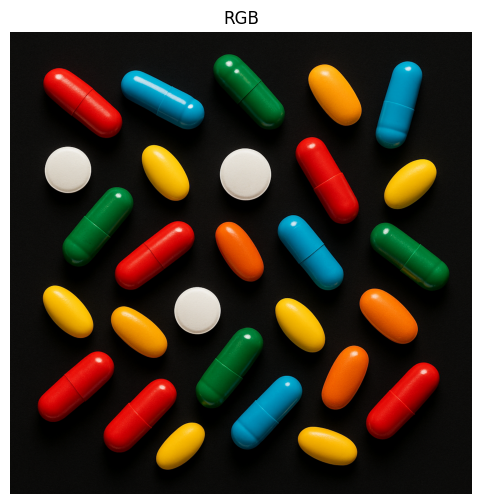

In [2]:
bgr = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)
if bgr is None:
    raise FileNotFoundError(f"No se pudo cargar: {IMG_PATH}")
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6)); plt.imshow(rgb); plt.title("RGB"); plt.axis("off"); plt.show()

Conversión a gris, suavizado y umbralización (Otsu) con polaridad automática.

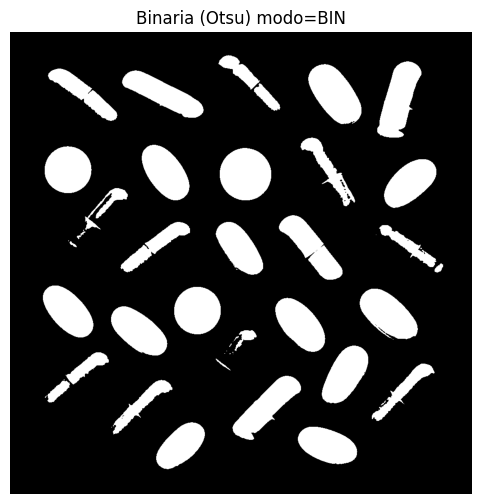

In [3]:
gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (5,5), 0)
use_inverse = gray_blur.mean() > 127
mode = cv2.THRESH_BINARY_INV if use_inverse else cv2.THRESH_BINARY
_, bin_img = cv2.threshold(gray_blur, 0, 255, mode + cv2.THRESH_OTSU)
plt.figure(figsize=(6,6)); plt.imshow(bin_img, cmap="gray"); plt.title(f"Binaria (Otsu) modo={'INV' if use_inverse else 'BIN'}"); plt.axis("off"); plt.show()

Detección de contornos externos y visualización.

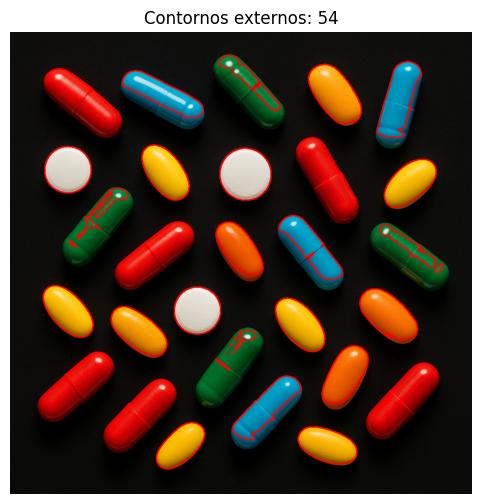

In [4]:
contours, hierarchy = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
vis = rgb.copy()
cv2.drawContours(vis, contours, -1, (255,0,0), 2)
plt.figure(figsize=(6,6)); plt.imshow(vis); plt.title(f"Contornos externos: {len(contours)}"); plt.axis("off"); plt.show()

Funciones auxiliares para descriptores.

In [5]:
def contour_descriptors(cnt):
    area = cv2.contourArea(cnt)
    perim = cv2.arcLength(cnt, True)
    x,y,w,h = cv2.boundingRect(cnt)
    rect_area = w*h
    # Circularidad: 4πA / P^2 (1 = círculo)
    circularity = (4*np.pi*area)/(perim**2) if perim>0 else 0
    # Solidez: A / A_casco (1 = convexo)
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = (area/hull_area) if hull_area>0 else 0
    # Relación de aspecto: w/h
    aspect = (w/h) if h>0 else 0
    # Excentricidad aproximada a partir de elipse ajustada
    ecc = np.nan
    if len(cnt) >= 5:
        (cx,cy),(MA,ma),angle = cv2.fitEllipse(cnt)
        a = max(MA,ma)/2.0; b = min(MA,ma)/2.0
        if a>0: ecc = np.sqrt(1 - (b*b)/(a*a))
    # Momentos de Hu (log-scale con signo preservado)
    hu = cv2.HuMoments(cv2.moments(cnt)).flatten()
    hu_log = np.array([-np.sign(h)*np.log10(abs(h)) if h!=0 else 0 for h in hu])
    return dict(area=area, perimetro=perim, x=x, y=y, w=w, h=h, circularidad=circularity,
                solidez=solidity, aspecto=aspect, excentricidad=ecc,
                hu1=hu_log[0], hu2=hu_log[1], hu3=hu_log[2], hu4=hu_log[3], hu5=hu_log[4], hu6=hu_log[5], hu7=hu_log[6])

Cálculo de descriptores por contorno y tabla de resultados.

In [6]:
rows = []
for i, cnt in enumerate(contours, start=1):
    d = contour_descriptors(cnt)
    d['ID'] = i
    rows.append(d)
df = pd.DataFrame(rows).set_index('ID').sort_index()
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
df

,area,perimetro,x,y,w,h,circularidad,solidez,aspecto,excentricidad,hu1,hu2,hu3,hu4,hu5,hu6,hu7
ID,,,,,,,,,,,,,,,,,
1,7620.0000,356.1909,638,875,132,83,0.7547,0.9883,1.5904,0.8592,0.7093,1.8937,5.2529,6.5090,-12.4471,-7.4961,12.7077
2,0.0000,0.0000,230,875,1,1,0.0000,0.0000,1.0000,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,2.0000,225,875,1,2,0.0000,0.0000,0.5000,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,6809.0000,334.4752,324,865,108,104,0.7648,0.9873,1.0385,0.8562,0.7066,1.8805,4.6763,5.5098,10.6213,6.4870,-11.1478
5,0.0000,0.0000,817,836,1,1,0.0000,0.0000,1.0000,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,17.0000,31.7990,822,817,11,11,0.2113,0.6800,1.0000,0.9814,0.0531,0.1415,1.1937,1.2943,2.5385,1.3961,4.0080
7,4.5000,11.8995,77,806,5,5,0.3994,0.8182,1.0000,0.9768,0.3757,0.8617,1.7482,1.9656,3.8238,2.4044,-4.9410
8,1078.0000,161.3381,83,773,50,48,0.5204,0.9006,1.0417,0.9467,0.5702,1.3405,3.9135,4.7915,9.8531,-6.2119,9.1524
9,3788.5000,441.7716,228,771,132,121,0.2439,0.6889,1.0909,0.9837,0.2436,0.5357,2.2322,2.7046,5.2290,3.1671,5.4947


Visualización: color por circularidad; IDs y bounding boxes.

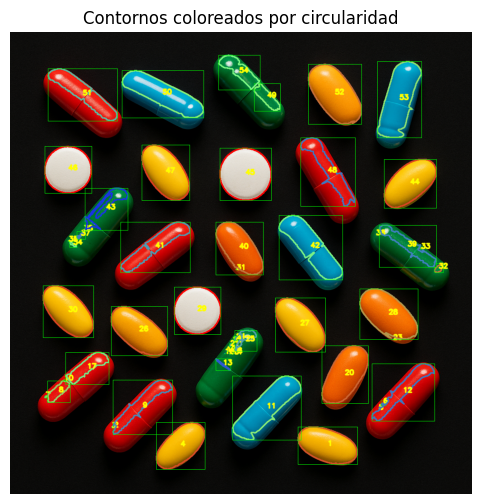

In [7]:
vis_desc = rgb.copy()
min_c, max_c = float(df['circularidad'].min()), float(df['circularidad'].max())
def color_map(val, vmin, vmax):
    if vmax<=vmin: return (255,255,255)
    t = (val - vmin)/(vmax - vmin)
    # mapa simple azul->verde->rojo
    r = int(255*t)
    g = int(255*(1-abs(t-0.5)*2))
    b = int(255*(1-t))
    return (r,g,b)

for i, cnt in enumerate(contours, start=1):
    x,y,w,h = cv2.boundingRect(cnt)
    cval = float(df.loc[i,'circularidad']) if i in df.index else 0.0
    col = color_map(cval, min_c, max_c)
    cv2.drawContours(vis_desc, [cnt], -1, col, 2)
    cv2.rectangle(vis_desc, (x,y), (x+w,y+h), (0,255,0), 1)
    cx = int(x + w/2); cy = int(y + h/2)
    cv2.putText(vis_desc, str(i), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0), 2, cv2.LINE_AA)

plt.figure(figsize=(6,6)); plt.imshow(vis_desc); plt.title("Contornos coloreados por circularidad"); plt.axis("off"); plt.show()

- Circularidad ≈ 1 indica formas cercanas a círculo; valores menores indican formas alargadas.
- Solidez < 1 indica concavidades o contornos con irregularidades respecto a su casco convexo.
- Excentricidad en [0,1); cercana a 0 ≈ círculo, cercana a 1 ≈ elipse muy alargada.
- Momentos de Hu (log) son invariantes a traslación, escala y rotación (sensibles al ruido).
